In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML, IFrame, Image, SVG, Latex
import ROOT
from ROOT import RooFit, RooStats
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

Welcome to JupyROOT 6.10/02


In [2]:
from create_example_ws import create_example_onoff as create_example

ws = create_example()

# create references to useful variables
model_config = ws.obj('model_config')
pdf = model_config.GetPdf()
obs = model_config.GetObservables()
poi = model_config.GetParametersOfInterest().first()

[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing dataset data_toy_signal
[#1] INFO:ObjectHandling -- RooWorkspace::import(ws) importing dataset data_toy_nosignal


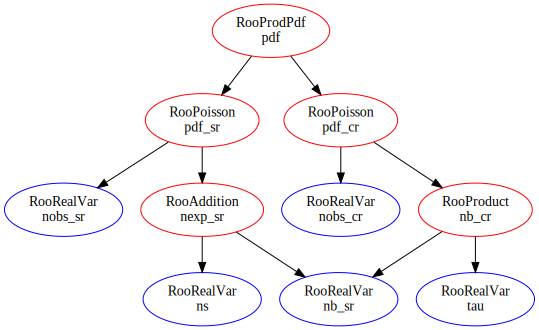

In [3]:
pdf.graphVizTree("pdf_graph.dot")
!dot -Tsvg pdf_graph.dot > pdf_graph.svg; rm pdf_graph.dot
SVG("pdf_graph.svg")

In [4]:
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Eval) 
ROOT.RooMsgService.instance().setGlobalKillBelow(RooFit.ERROR)
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.NumIntegration) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Fitting) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Minimization) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.InputArguments) 
ROOT.RooMsgService.instance().getStream(1).removeTopic(RooFit.Eval) 
ROOT.RooMsgService.instance().setGlobalKillBelow(RooFit.ERROR)
ROOT.RooMsgService.instance().setSilentMode(True);

In [5]:
# create a useful function to create toys specific for this workspace
def create_toy():
    return pdf.generate(obs, 1)

# just an example
data = create_toy()
data.get(0).Print("v")

  1) 0x55dfee23a5f0 RooRealVar:: nobs_sr = 7  L(0 - 1500)  "nobs_sr"
  2) 0x55dfee1d0430 RooRealVar:: nobs_cr = 7  L(0 - 900)  "nobs_cr"


In [6]:
from functools import wraps

def stateless(varnames):
    def decorator(method):
        @wraps(method)
        def f(*args, **kwargs):
            old_values = {v: ws.var(v).getVal() for v in varnames}
            result = method(*args, **kwargs)
            for k, v in old_values.iteritems():
                ws.var(k).setVal(v)
                ws.var(k).setConstant(False)
            return result
        return f
    return decorator

@stateless([poi.GetName()])
def evaluate_test_stat(test_value, data):
   
    # uncond fit
    poi.setConstant(False)
    r = pdf.fitTo(data, RooFit.Save())
    denominator = r.minNll()
    
    # special case, we are not interested in these cases
    if poi.getVal() > test_value:
        return 0.
    
    # recompute if needed
    if poi.getVal() < 0:
        poi.setVal(0)
        poi.setConstant(True)
        r = pdf.fitTo(data, RooFit.Save())
        denominator = r.minNll()
        
    # conditional fit
    poi.setVal(test_value)
    poi.setConstant(True)
    r = pdf.fitTo(data, RooFit.Save())
    numerator = r.minNll()
    
    return numerator - denominator

In [7]:
nsignal_toys = 10000
nbkg_toys = 10000

test_poi_values = np.linspace(0.1, 6, 2)

all_qvalue_data = {}
all_qvalues_signal_toys = {}
all_qvalues_bkg_toys = {}
all_clsb = {}
all_cls = {}
all_clb = {}

for test_poi_value in test_poi_values:
    print "computing", test_poi_value
    
    qvalue_data = evaluate_test_stat(test_poi_value, data)

    qvalues_signal_toys = []
    qvalues_bkg_toys = []

    for itoy in tqdm(range(nsignal_toys)):
        # create signal-sample toy
        poi.setVal(test_poi_value)
        poi.setConstant(True)
        pdf.fitTo(data)
        poi.setConstant(False)
        toy_s = create_toy()
        qvalues_signal_toys.append(evaluate_test_stat(test_poi_value, toy_s))


    for itoy in tqdm(range(nbkg_toys)):
        # create signal-sample toy
        poi.setVal(0)
        poi.setConstant(True)
        pdf.fitTo(data)
        poi.setConstant(False)
        toy_b = create_toy()
        qvalues_bkg_toys.append(evaluate_test_stat(test_poi_value, toy_b))
    
    
    all_qvalue_data[test_poi_value] = qvalue_data
    all_qvalues_signal_toys[test_poi_value] = np.array(qvalues_signal_toys)
    all_qvalues_bkg_toys[test_poi_value] = np.array(qvalues_bkg_toys)
    
    pvalue_sb = (all_qvalues_signal_toys[test_poi_value] >= qvalue_data).sum() / float(nsignal_toys)
    pvalue_b = (all_qvalues_bkg_toys[test_poi_value] >= qvalue_data).sum() / float(nbkg_toys)
    cls = pvalue_sb / (1 - pvalue_b)
    
    all_clsb[test_poi_value] = pvalue_sb
    all_clb[test_poi_value] = 1 - pvalue_b
    all_cls[test_poi_value] = cls

  0%|          | 0/10000 [00:00<?, ?it/s]

computing 0.1


  0%|          | 4/10000 [00:00<05:52, 28.35it/s]

computing 6.0


100%|██████████| 10000/10000 [10:17<00:00, 14.14it/s]


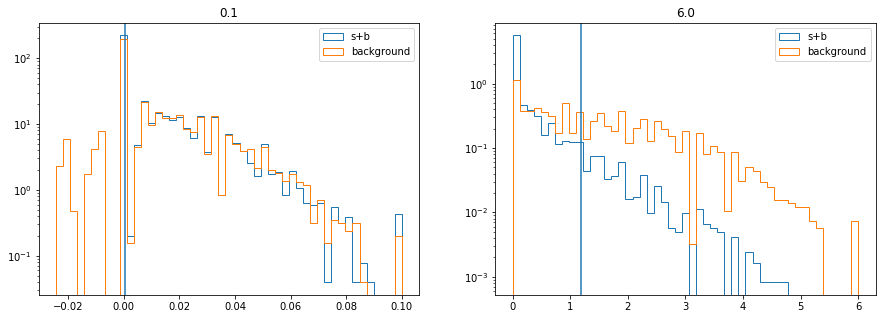

In [10]:
fig, axs = plt.subplots(1, len(test_poi_values), figsize=(15, 5))
for ax, test_poi_value in zip(axs.flat, test_poi_values):
    
    qvalue_data = all_qvalue_data[test_poi_value]
    qvalues_signal_toys = all_qvalues_signal_toys[test_poi_value]
    qvalues_bkg_toys = all_qvalues_bkg_toys[test_poi_value]
    
    bins = np.linspace(min([np.min(qvalues_signal_toys), np.min(qvalues_bkg_toys)]),
                       max([np.max(qvalues_signal_toys), np.max(qvalues_bkg_toys)]), 50)
    ax.hist(qvalues_signal_toys, bins=bins, histtype='step', label='s+b', normed=True)
    ax.hist(qvalues_bkg_toys, bins=bins, histtype='step', label='background', normed=True)
    ax.axvline(qvalue_data)
    ax.set_title(test_poi_value)
    ax.set_yscale('log')
    ax.legend()

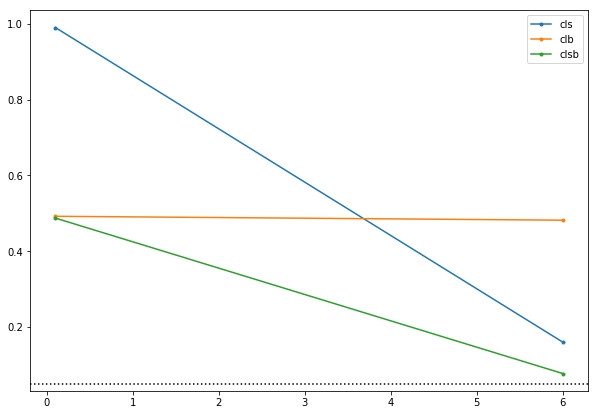

In [11]:
def get_xy(d):
    xs = sorted(d.keys())
    ys = [d[x] for x in xs]
    return xs, ys

fig, ax = plt.subplots(figsize=(10, 7))

x, y = get_xy(all_cls)
ax.plot(x, y, '.-', label='cls')

x, y = get_xy(all_clb)
ax.plot(x, y, '.-', label='clb')

x, y = get_xy(all_clsb)
ax.plot(x, y, '.-', label='clsb')

ax.axhline(0.05, ls=":", color='k')
ax.legend(loc=0)

In [3]:
import sympy
from sympy import symbols, diff, init_printing, simplify, lambdify
from sympy.solvers import solve
from sympy import stats
from sympy.plotting import plot3d
init_printing() 

In [134]:
ns, theta = symbols('ns theta', real=True)
NBEXP, SIGMA = symbols('NBEXP, SIGMA', positive=True)
nobs = symbols('nobs', positive=True)

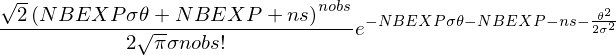

In [135]:
poisson = sympy.stats.density(sympy.stats.Poisson('X_ns', ns + NBEXP * (1 + SIGMA * theta)))(nobs)
gaussian = sympy.stats.density(sympy.stats.Normal('X_G', theta, SIGMA))(0)
likelihood = poisson * gaussian
simplify(likelihood)

In [136]:
solution = solve([diff(likelihood, ns),
                  diff(likelihood, theta)], ns, theta, dict=True, check=True)[0]
ns_hat = solution[ns]
theta_hat = solution[theta]
solution

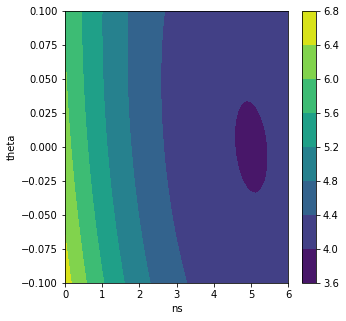

In [137]:
example = {nobs:15, NBEXP:10, SIGMA:0.3}
likelihood_example = likelihood.subs(example)
example_solution = [float(sympy.N(solution[x].subs(example))) for x in (ns, theta)]
likelihood_example = lambdify((ns, theta), likelihood_example, modules=['numpy'])
X, Y = np.meshgrid(np.linspace(0, 6, 50), np.linspace(-.1, .1, 50))
fig, ax = plt.subplots(figsize=(5, 5))
pc = ax.contourf(X, Y, -2 * np.log(likelihood_example(X, Y)))
fig.colorbar(pc)
ax.set_xlabel(ns)
ax.set_ylabel(repr(theta))
ax.legend()

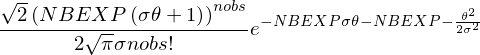

In [138]:
likelihood_bkg_only = likelihood.subs({ns: 0})
simplify(likelihood_bkg_only)

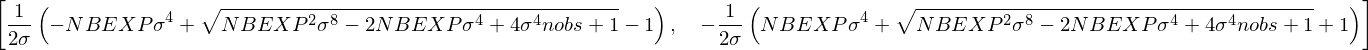

In [139]:
theta_hat_hat_solutions = solve(diff(likelihood_bkg_only, theta), theta)
theta_hat_hat = theta_hat_hat_solutions[0]
simplify(theta_hat_hat_solutions)

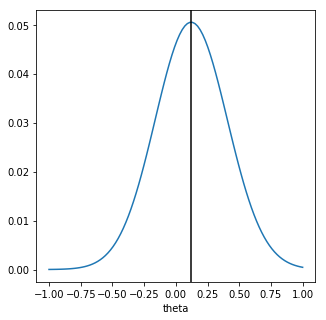

In [140]:
likelihood_bkg_only_example = likelihood_bkg_only.subs(example)
likelihood_bkg_only_example = lambdify(theta, likelihood_bkg_only_example, modules=['numpy'])
X = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X, (likelihood_bkg_only_example(X)))
ax.axvline(simplify(theta_hat_hat).subs(example), color='k')
ax.set_xlabel(theta)
plt.show()

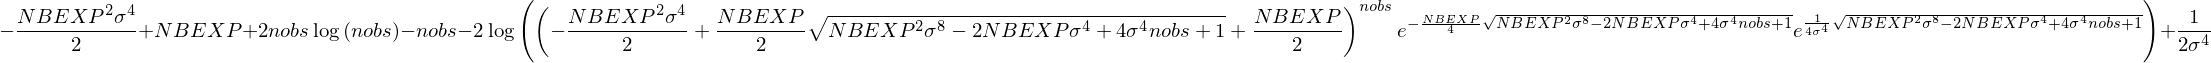

In [148]:
denominator = likelihood.subs({ns: ns_hat, theta: theta_hat})
numerator = likelihood_bkg_only.subs({theta: theta_hat_hat})
q0 = - 2 * sympy.log(numerator / denominator)
significance = sympy.sqrt(q0)
sympy.expand(q0)